In [70]:
from collections import defaultdict
import numpy as np
import random as rd
import copy
import networkx
import matplotlib.pyplot as plt

In [71]:
def make_graph_matrices(num_vertices):
    rd.seed(1)
    edges = []
    vertices = list(range(num_vertices))
    # Initialize adjacency matrix
    def init_adjacency_matrix(nodes, edges):
        adjacency_matrix = np.zeros((nodes,nodes),dtype = np.int)
        edge_probability = .085
        edges_cnt = 0
        for i in range(nodes):
            for j in range(i):
                prob = rd.random()
                if prob < edge_probability:
                    adjacency_matrix[i,j] = 1
                    edges.append((i,j))
                    edges_cnt += 1
        return adjacency_matrix, edges
    adjacency_matrix, edges = init_adjacency_matrix(num_vertices, edges)
    G=networkx.Graph()
    G.add_nodes_from(list(range(num_vertices)))
    G.add_edges_from(edges)
    adjacency_list = networkx.to_dict_of_lists(G)
    return adjacency_list,adjacency_matrix, edges, G

In [72]:
def calc_prob(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices):
    probs = {} #keys -> probs; vals -> connected vertices
    sumprob = 0
    for j in range(len(possible_vertices)): #sum of all the paths the ant can take ( denominator )
        temp_connected_vertex = possible_vertices[j] #one of the connected vertices
        vertex_degree = len(set(adj_list[temp_connected_vertex]) - set(ant.history_vertices))
        sumprob += ((phermone_dict[temp_connected_vertex]*(vertex_degree)**alpha)/weight_dict[temp_connected_vertex]) 
    
    for j in range(len(possible_vertices)): #probability for each path
        temp_connected_vertex = possible_vertices[j] #one of the connected vertices
        vertex_degree = len(set(adj_list[temp_connected_vertex]) - set(ant.history_vertices))
        probs_key = ((phermone_dict[temp_connected_vertex]*(vertex_degree)**alpha)/weight_dict[temp_connected_vertex])/sumprob
        
        if probs_key not in probs:
            probs[probs_key] = [temp_connected_vertex]
        else:
            probs[probs_key].append(temp_connected_vertex)

    probs = dict(sorted(probs.items(), key=lambda item: item[0]))
    return probs

In [73]:
class Ant:
    def __init__(self, number) -> None:
        self.number = number
        self.history_vertices = []
        self.last_visited = {}

    def __str__(self):
        return f"Ant {self.number}"

    def add_to_visited(self, end_vertex):
        self.history_vertices.append(end_vertex)
        self.last_visited = end_vertex
        
    def status(self):
        print(f"self.number: {self.number}")
        print(f"self.history_vertices: {self.history_vertices}")
        print(f"self.last_visited: {self.last_visited}")
        return

    def get_path_len(self):
        path_length = len(self.history_vertices)
        return self.number, path_length -1

In [74]:
def initialize(num_vertices, num_ants):
    adj_list, adj_mat, edges, G = make_graph_matrices(num_vertices) #Adjacency list of the n-hypercube graph
    return num_vertices, num_ants, adj_list, adj_mat, edges, G

In [75]:
def select_choice_vertex(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices):
    probs = calc_prob(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices)
    random_num = rd.random()
    cumsum_probs = dict(zip(np.cumsum(np.multiply(list(probs.keys()), [len(i) for i in probs.values()])), list(probs.values())))
    for prob in cumsum_probs:
        if random_num < prob:
            return rd.choice(cumsum_probs[prob])

In [76]:
def find_possible_vertices(ant, adj_list, no_visit_vertices):
    possible_vertices = set(adj_list) - set(ant.history_vertices)
    possible_vertices -= no_visit_vertices
    return list(possible_vertices)

In [77]:
def edges_covered(ant_edges):
    for ant,val in ant_edges:
        if not val:
            return True

In [78]:
def no_edge_vertices(adj_mat):
    ans = set()
    for vertex,row in enumerate(adj_mat):
        if sum(row) == 0:
            ans.add(vertex)
    return ans

In [79]:
def run_ants_on_hypercube_random_colors_optimized(n, num_ants): #  returns ((ant.number, path_length), iter)
    alpha = 2
    q_0 = 0.5
    num_vertices, num_ants, adj_list, adj_mat, edges, G = initialize(n, num_ants)
    ant_edges = {i:copy.deepcopy(edges) for i in range(num_ants)}
    pheromone_dict = {i:0.1 for i in range(num_vertices)}
    weight_dict = {i:1 for i in range(num_vertices)}
    evaporation_rate = 0.001
    iter = 0
    breaker = False
    no_visit_vertices = no_edge_vertices(adj_mat)
    
    #initialize ants 
    ants_list = [Ant(i) for i in range(num_ants)]
    return_ants_list = []
    #The fun begins
    while len(return_ants_list) != num_ants:
        print("iteration: ", iter)
        if breaker:
            break
        
        local_pheromone_dict = defaultdict(float)
        for ant_number in range(num_ants):
            curr_ant = ants_list[ant_number]
            if curr_ant in return_ants_list:
                continue
            if not ant_edges[ant_number]:
                return_ants_list.append(curr_ant)
                continue
            possible_vertices = find_possible_vertices(curr_ant, adj_list, no_visit_vertices)
            if len(possible_vertices) == 0: 
                print(f"Ant: {ant_number} is out of vertices to go to")
                continue

            else:
                choice_vertex = select_choice_vertex(curr_ant, adj_list, pheromone_dict, weight_dict, alpha, q_0, possible_vertices)
               
            curr_ant.add_to_visited(choice_vertex)
            local_pheromone_dict[choice_vertex] += 1/weight_dict[choice_vertex]
            ant_edges[ant_number] = [edge for edge in ant_edges[ant_number] if choice_vertex not in edge]
    
        for vertex in local_pheromone_dict:
            pheromone_dict[vertex] = (1-evaporation_rate)*pheromone_dict[vertex] + local_pheromone_dict[vertex]
        iter += 1
    return return_ants_list, G, weight_dict


In [80]:
ants_list, G, vertex_weights = run_ants_on_hypercube_random_colors_optimized(100,30)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
itera

80


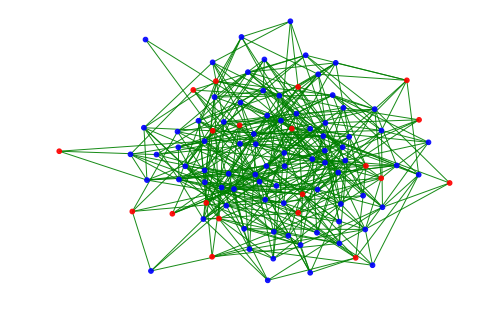

1.0
ACO: 80


In [81]:
color_map = []
min_num = 100000000000
solutions = []
for ant in ants_list:
    if len(ant.history_vertices) < min_num:
        print(len(ant.history_vertices))
        min_num = len(ant.history_vertices)
        solutions = ant.history_vertices
        
for node in G:
    if node in solutions:
        color_map.append('blue')
    else: 
        color_map.append('red')      

edge_colours = []
for (u,v) in G.edges():
    if u in solutions or v in solutions:
        edge_colours.append("green")
    else:
        edge_colours.append("red")
        
nx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=22, alpha=0.9)
plt.show()

edges_visited = 0
for col in edge_colours:
    if col == "green":
        edges_visited+=1
print(edges_visited/len(edge_colours))
ant_cost = 0
for vertex in solutions:
    ant_cost += vertex_weights[vertex]
print(f"ACO: {ant_cost}")